In [1]:
'''
To compute CD signatures for LINCS L1000 level3 data using 
all profiles in the same batch as controls
and add results to mongodb.
''' 
import os, sys, json
import h5py
from pymongo import MongoClient
import geode

def file2list(fn, idx, sep='\t', header=False):
	"""read a file into a list"""
	l = []
	with open (fn, 'r') as f:
		if header:
			next(f)
		for line in f:
			if not line.startswith('#'):
				sl = line.strip().split(sep)
				t = sl[idx]
				l.append(t)
	return l


In [2]:
import numpy as np
import pandas as pd

# 0. Load LINCS L1000 level 3 data from gctx file and made function to subset this matrix by probe_ids and sample_ids

In [3]:
# GCTX_FILE = '../../q2norm_n1328098x22268.gctx'
# PROBES = json.load(open('../data/rid.json', 'rb'))
# PROBES_LM1000 = file2list('../data/rid_lm1000.txt', 0)

GCTX_FILE = '/Users/zichen/Documents/Zichen_Projects/L1000_DR/data/q2norm_n1328098x22268.gctx'
PROBES = json.load(open('/Users/zichen/Documents/bitbucket/lincs_l1000_limma/rid.json', 'rb'))
PROBES_LM1000 = file2list('/Users/zichen/Documents/bitbucket/lincs_l1000_limma/rid_lm1000.txt', 0)

print len(PROBES), len(PROBES_LM1000)
print PROBES[:5]
print PROBES_LM1000[:5]

22268 978
[u'200814_at', u'222103_at', u'201453_x_at', u'204131_s_at', u'200059_s_at']
['200814_at', '222103_at', '201453_x_at', '204131_s_at', '200059_s_at']


In [4]:
gctx = h5py.File(GCTX_FILE, 'r')
mat = gctx['/0/DATA/0/matrix']
print mat.shape

gene_ids = list(gctx['/0/META/ROW/id'])
print len(gene_ids), gene_ids[:5]

(1328098, 22268)
22268 ['200814_at', '222103_at', '201453_x_at', '204131_s_at', '200059_s_at']


In [5]:
gctx['/0/META/COL/id'][:5]

array(['CPC005_A375_6H_X1_B3_DUO52HI53LO:K06',
       'CPC005_A375_6H_X2_B3_DUO52HI53LO:K06',
       'CPC005_A375_6H_X3_B3_DUO52HI53LO:K06',
       'CPC005_A375_6H_X1_B3_DUO52HI53LO:C19',
       'CPC005_A375_6H_X2_B3_DUO52HI53LO:C19'],
      dtype='|S46')

In [6]:
print np.in1d(PROBES, PROBES_LM1000).sum()
print np.in1d(PROBES, PROBES_LM1000)[:978].sum()

978
978


In [7]:
def slice_matrix(gctx, cids, rids):
    '''Slice the mat by cids and rids and ensure the mat 
    is ordered by cids and rids.'''    
    all_cids = gctx['/0/META/COL/id']
    c_mask = np.in1d(all_cids, cids)
    cids_subset = all_cids[c_mask].tolist()
    c_indices = np.array([cids_subset.index(id_) 
                          for id_ in cids])

    mat = gctx['/0/DATA/0/matrix']
    submat = mat[c_mask, :][c_indices, :]
    
    all_rids = gctx['/0/META/ROW/id']
    r_mask = np.in1d(all_rids, rids)
    rids_subset = all_rids[r_mask].tolist()
    r_indices = np.array([rids_subset.index(id_) 
                          for id_ in rids])
    submat = submat[:, r_mask][:, r_indices]

    return submat

# 1. Connect to MongoDB to retrieve all `sig_id`s that are `trt_cp`

In [8]:
client = MongoClient("mongodb://146.203.54.131:27017")
# DB = client['LINCS_L1000_limma']
# COLL_SIG = DB['siginfo'] # to get metadata
DB = client['L1000FWD']
COLL_SIG = DB['sigs']

In [9]:
# Collect pert_ids and batches
cur = COLL_SIG.find({'SCS_centered_by_batch':{'$lt': 0.05}}, 
                    {'_id':False, 'sig_id':True, 'distil_id':True})
print cur.count()


48098


In [10]:
# Retrieve sig_meta from the MongoDB
sig_meta_df_full = pd.DataFrame([doc for doc in cur]).set_index('sig_id')
print sig_meta_df_full.shape
sig_meta_df_full.head()

(48098, 1)


,distil_id
sig_id,
LJP001_HS578T_24H:BRD-K52911425-001-04-9:2,"[LJP001_HS578T_24H_X1_F2B5_DUO52HI53LO:I06, LJ..."
LJP001_HS578T_24H:BRD-K69932463-001-05-6:10,"[LJP001_HS578T_24H_X1_F2B5_DUO52HI53LO:A15, LJ..."
LJP001_HS578T_24H:BRD-K85606544-001-04-2:10,"[LJP001_HS578T_24H_X1_F2B5_DUO52HI53LO:C15, LJ..."
LJP001_HS578T_24H:BRD-K72636697-001-01-5:10,"[LJP001_HS578T_24H_X1_F2B5_DUO52HI53LO:M17, LJ..."
LJP001_HS578T_24H:BRD-K13390322-001-02-2:0.4,"[LJP001_HS578T_24H_X1_F2B5_DUO52HI53LO:B09, LJ..."


In [11]:
# Get batch info
sig_meta_df_full['batch'] = sig_meta_df_full.index.map(lambda x:x.split(':')[0])
print sig_meta_df_full['batch'].nunique()


649


In [13]:
# Get all the distil_ids
COLL_INST = client['LINCS_L1000_limma']['instinfo']
cur = COLL_INST.find({'pert_type': {'$in' : ['trt_cp', 'trt_poscon']}}, 
                     {'_id':False, 
                      'distil_id':True, 
                      'pert_id':True,
                      'det_plate':True,
                     })

distil_df = pd.DataFrame([doc for doc in cur]).set_index('distil_id')
print distil_df.shape
distil_df.head()

(675657, 2)


,det_plate,pert_id
distil_id,,
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:A06,ASG001_MCF7_24H_X1_B7_DUO52HI53LO,BRD-A60070924
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:B06,ASG001_MCF7_24H_X1_B7_DUO52HI53LO,BRD-A60070924
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:C06,ASG001_MCF7_24H_X1_B7_DUO52HI53LO,BRD-A60070924
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:D06,ASG001_MCF7_24H_X1_B7_DUO52HI53LO,BRD-A60070924
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:E06,ASG001_MCF7_24H_X1_B7_DUO52HI53LO,BRD-A60070924


In [14]:
def distil_id_to_rna_plate(did):
    return '_'.join(did.split('_')[:4])

def distil_id_to_batch(did):
    return '_'.join(did.split('_')[:3])

def distil_id_to_det_plate(did):
    return '_'.join(did.split('_')[:5])

# distil_df['det_plate'] = distil_df.index.map(distil_id_to_det_plate)
distil_df['rna_plate'] = distil_df.index.map(distil_id_to_rna_plate)
distil_df['batch'] = distil_df.index.map(distil_id_to_batch)
distil_df.head()

,det_plate,pert_id,rna_plate,batch
distil_id,,,,
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:A06,ASG001_MCF7_24H_X1_B7_DUO52HI53LO,BRD-A60070924,ASG001_MCF7_24H_X1,ASG001_MCF7_24H
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:B06,ASG001_MCF7_24H_X1_B7_DUO52HI53LO,BRD-A60070924,ASG001_MCF7_24H_X1,ASG001_MCF7_24H
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:C06,ASG001_MCF7_24H_X1_B7_DUO52HI53LO,BRD-A60070924,ASG001_MCF7_24H_X1,ASG001_MCF7_24H
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:D06,ASG001_MCF7_24H_X1_B7_DUO52HI53LO,BRD-A60070924,ASG001_MCF7_24H_X1,ASG001_MCF7_24H
ASG001_MCF7_24H_X1_B7_DUO52HI53LO:E06,ASG001_MCF7_24H_X1_B7_DUO52HI53LO,BRD-A60070924,ASG001_MCF7_24H_X1,ASG001_MCF7_24H


In [46]:
COLL_GENES = client['LINCS_L1000_limma']['geneinfo']
cur = COLL_GENES.find({}, {'_id':False ,'pr_id':True, 'pr_gene_symbol':True})
probes2genes = pd.DataFrame([doc for doc in cur])
print probes2genes.shape
probes2genes.head()


(22269, 2)


,pr_gene_symbol,pr_id
0,-666,202938_x_at
1,-666,204006_s_at
2,-666,204060_s_at
3,-666,204419_x_at
4,-666,204438_at


In [47]:
probes2genes = probes2genes.replace({'-666': None}).dropna(axis=0)
print probes2genes.shape
probes2genes.head()

(20336, 2)


,pr_gene_symbol,pr_id
1820,A1CF,220951_s_at
1821,A2M,217757_at
1822,A4GALT,219488_at
1823,A4GNT,221131_at
1824,AAAS,218075_at


In [48]:
print probes2genes['pr_gene_symbol'].nunique()
print probes2genes['pr_id'].nunique()

12716
20336


In [49]:
probes2genes = dict(zip(probes2genes['pr_id'], probes2genes['pr_gene_symbol']))
print len(probes2genes)

20336


# 2. Apply normalization for each batch, then compute signatures and insert in to MongoDB

The normalization method is described in [Iskar et al PLoS comp Bio, 2010]():

```
for batch in batches:
    1. discard control samples
    2. mean center each probe across treatment samples in batch
    3. average replicate treatment samples as the signature
```

In [15]:
# Make MongoDB to store those data
# client_local = MongoClient('mongodb://127.0.0.1:27017')
# db = client_local['L1000FWD']
db = client['L1000FWD']
coll = db['sigs']
# coll.create_index('sig_id', unique=True)

In [16]:
from joblib import delayed, Parallel

In [18]:
from scipy import stats

In [17]:
def compute_signatures(sig_id, row, distil_ids_sub, mat, mat_centered, PROBES_LM1000):
    distil_ids_pert = row['distil_id']
    # Make the sample_class
    mask_pert = np.in1d(distil_ids_sub, distil_ids_pert)
    sample_class = mask_pert.astype(int) + 1
    sample_class = list(sample_class)

    # Apply CD on the original mat
    cd1 = geode.chdir(mat.T, sample_class, PROBES_LM1000, 
                      calculate_sig=0, sort=False, gamma=0.5)

    # Apply CD on the mean centered mat
    cd2 = geode.chdir(mat_centered.T, sample_class, PROBES_LM1000, 
                      calculate_sig=0, sort=False, gamma=0.5)
    # Averaging profiles after mean centering
    avg_vals = mat_centered[mask_pert].mean(axis=0)

    doc = row.to_dict()
    doc['sig_id'] = sig_id
    doc['CD_nocenter_LM'] = list(np.array([item[0] for item in cd1], dtype=np.float64))
    doc['CD_center_LM'] = list(np.array([item[0] for item in cd2], dtype=np.float64))
    doc['avg_center_LM'] = list(avg_vals.astype(np.float64))

    return doc

In [28]:
from sklearn.decomposition import PCA
from scipy.stats import chi2
from scipy.stats.mstats import zscore
def fast_chdir(data, sampleclass):
    m1 = sampleclass == 1
    m2 = sampleclass == 2
    
    gamma = 0.5
    
    data = zscore(data)
    
    ## start to compute
    n1 = m1.sum() # number of controls
    n2 = m2.sum() # number of experiments

    ## the difference between experiment mean vector and control mean vector.
    meanvec = data[:,m2].mean(axis=1) - data[:,m1].mean(axis=1) 

    ## initialize the pca object
    pca = PCA(n_components=None)
    pca.fit(data.T)

    ## compute the number of PCs to keep
    cumsum = pca.explained_variance_ratio_ # explained variance of each PC
    keepPC = len(cumsum[cumsum > 0.001]) # number of PCs to keep
    v = pca.components_[0:keepPC].T # rotated data 
    r = pca.transform(data.T)[:,0:keepPC] # transformed data

    dd = ( np.dot(r[m1].T,r[m1]) + np.dot(r[m2].T,r[m2]) ) / float(n1+n2-2) # covariance
    sigma = np.mean(np.diag(dd)) # the scalar covariance

    shrunkMats = np.linalg.inv(gamma*dd + sigma*(1-gamma)*np.eye(keepPC))

    b = np.dot(v, np.dot(np.dot(v.T, meanvec), shrunkMats))

    b /= np.linalg.norm(b) # normalize b to unit vector
    
    return b


In [20]:
def fast_chdir_with_pvals(data, sampleclass):
    cd_coefs = fast_chdir(data, sampleclass)
    zscores = stats.zscore(cd_coefs)
    pvals = stats.norm.sf(np.abs(zscores))*2 # two-sided
    return cd_coefs, pvals

In [64]:
def compute_signatures_full(sig_id, row, distil_ids_sub, mat_centered, PROBES, probes2genes):
    
    distil_ids_pert = row['distil_id']
    # Make the sample_class
    mask_pert = np.in1d(distil_ids_sub, distil_ids_pert)
    sample_class = mask_pert.astype(int) + 1

    # Apply CD on the mean centered mat
    cd_coefs, pvals = fast_chdir_with_pvals(mat_centered.T, sample_class)
    sigIdx = np.where(pvals < 0.01)[0].astype(int)
        
    # Identify significant up/down genes
    up_probes = np.array(PROBES)[(cd_coefs > 0) & (pvals< 0.01)]
    upGenes = filter(None, set([probes2genes.get(pr_id) for pr_id in up_probes]))

    dn_probes = np.array(PROBES)[(cd_coefs < 0) & (pvals< 0.01)]
    dnGenes = filter(None, set([probes2genes.get(pr_id) for pr_id in dn_probes]))
    
    
    doc = {}
    doc['sig_id'] = sig_id
    doc['CD_center_Full'] = list(cd_coefs.astype(np.float64))
    doc['pvalues_Full'] = list(pvals.astype(np.float64))
    doc['sigIdx'] = list(sigIdx)
    doc['upGenes'] = upGenes
    doc['dnGenes'] = dnGenes
    return doc
    

In [54]:
type(PROBES)

list

In [57]:
up_probes = np.array(PROBES)[(cd_coefs > 0) & (pvals< 0.01)]
upGenes = filter(None, set([probes2genes.get(pr_id) for pr_id in up_probes]))
print len(up_probes), len(upGenes)
print type(upGenes)

267 222
<type 'list'>


In [65]:
doc = compute_signatures_full(sig_id, row, distil_ids_sub, mat_centered, PROBES, probes2genes)
print doc.keys()

['dnGenes', 'pvalues_Full', 'CD_center_Full', 'sig_id', 'upGenes', 'sigIdx']


In [63]:
print len(doc['sigIdx'])
print len(doc['upGenes']), len(doc['dnGenes'])

585
222 259


## The first round of recomputing signatures: `mat` was centered by `batch` like `CPC004_PC3_6H`

1. CD_nocenter_LM
2. CD_center_LM
3. avg_center_LM

In [22]:
# Get all inserted document sig_ids
# inserted_sig_ids = set(coll.distinct('sig_id'))
# print 'Number of sig_ids inserted: %d' % len(inserted_sig_ids)

# sig_ids_left = list(set(sig_meta_df.index) - inserted_sig_ids)

# subset the sig_meta_df
# sig_meta_df_left = sig_meta_df.ix[sig_ids_left]

all_batches = sig_meta_df_full['batch'].unique()
n_batches = len(all_batches)
print sig_meta_df_full.shape

for c, batch in enumerate(all_batches):
    sig_meta_df_sub = sig_meta_df_full.query('batch == "%s"' % batch)
    
    # all the treatment samples in this batch
    distil_ids_sub = reduce(lambda x, y: x + y, 
                            sig_meta_df_full.query('batch == "%s"' % batch)['distil_id'])
    print c, n_batches
    print '\t', batch, sig_meta_df_sub.shape, len(distil_ids_sub)
    # Slice the matrix
    mat = slice_matrix(gctx, distil_ids_sub, PROBES)
    print '\t', mat.shape
    # Mean center the probes
    mat_centered = mat - mat.mean(axis=0)
#     try:
#         docs = Parallel(n_jobs=7, backend='multiprocessing', verbose=10)(\
#                                   delayed(compute_signatures)(sig_id, row, distil_ids_sub, mat, mat_centered, PROBES_LM1000)\
#                                   for sig_id, row in sig_meta_df_sub.iterrows())
#     except:
#         pass
#     else:                     
#         result = coll.insert_many(docs)
    print mat_centered.shape
    break

    


(48098, 2)
0 649
	LJP001_HS578T_24H (118, 2) 349
	(349, 22268)
(349, 22268)


In [23]:
mat_centered.shape

(349, 22268)

In [24]:
sig_id, row = next(sig_meta_df_sub.iterrows())
print sig_id
row

LJP001_HS578T_24H:BRD-K52911425-001-04-9:2


distil_id    [LJP001_HS578T_24H_X1_F2B5_DUO52HI53LO:I06, LJ...
batch                                        LJP001_HS578T_24H
Name: LJP001_HS578T_24H:BRD-K52911425-001-04-9:2, dtype: object

In [26]:
len(distil_ids_sub)

349

In [31]:
distil_ids_pert = row['distil_id']
# Make the sample_class
mask_pert = np.in1d(distil_ids_sub, distil_ids_pert)
sample_class = mask_pert.astype(int) + 1
# sample_class = list(sample_class)

# Apply CD on the mean centered mat
cd_coefs, pvals = fast_chdir_with_pvals(mat_centered.T, sample_class)


In [32]:
print cd_coefs.shape, pvals.shape

(22268,) (22268,)


In [34]:
import matplotlib.pyplot as plt
%matplotlib inline

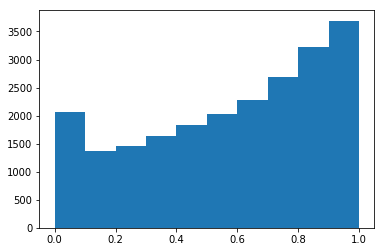

In [35]:
plt.hist(pvals);

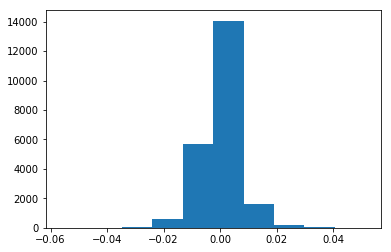

In [37]:
plt.hist(cd_coefs);

In [38]:
(pvals < 0.01).sum()

585

In [23]:
print sig_meta_df.shape
sig_meta_df.to_csv('data/sig_metadata_%d.csv' % sig_meta_df.shape[0])

(128017, 7)


## The 2nd round of recomputing signatures: `mat` was centered by `det_plate` like `ASG001_MCF7_24H_X1_B7`

In [19]:
def mean_center(mat, centerby):
    '''Mean center a mat based on centerby. mat is a samples x genes matrix'''
    mat_centered = np.zeros_like(mat)
    
    for group in set(centerby):
        mask = np.in1d(centerby, [group])
        mat_centered[mask] = mat[mask] - mat[mask].mean(axis=0)
    
    return mat_centered

In [21]:
def compute_signatures2(sig_id, row, distil_ids_sub, mat_centered, PROBES_LM1000):
    distil_ids_pert = row['distil_id']
    # Make the sample_class
    mask_pert = np.in1d(distil_ids_sub, distil_ids_pert)
    sample_class = mask_pert.astype(int) + 1

    # Apply CD on the mean centered mat
    cd = geode.chdir(mat_centered.T, sample_class, PROBES_LM1000, 
                      calculate_sig=0, sort=False, gamma=0.5)
    # Averaging profiles after mean centering
    avg_vals = mat_centered[mask_pert].mean(axis=0)

    doc = {}
    doc['sig_id'] = sig_id
    doc['CD_center_LM_det'] = list(np.array([item[0] for item in cd], dtype=np.float64))
    doc['avg_center_LM_det'] = list(avg_vals.astype(np.float64))

    return doc

In [22]:
def compute_sig2_wrapper(sig_id, row, distil_ids_sub, mat_centered, PROBES_LM1000):
    try:
        doc = compute_signatures2(sig_id, row, distil_ids_sub, mat_centered, PROBES_LM1000)
    except ValueError as e:
        doc = None
        print e
        pass
    return doc

In [23]:
key = 'CD_center_LM_det'
# Get all inserted document sig_ids
inserted_sig_ids = set(coll.find({key: {'$exists': True}}).distinct('sig_id'))
print 'Number of sig_ids inserted: %d' % len(inserted_sig_ids)


Number of sig_ids inserted: 27429


In [ ]:
sig_ids_left = list(set(sig_meta_df.index) - inserted_sig_ids)

# subset the sig_meta_df
sig_meta_df_left = sig_meta_df.ix[sig_ids_left]
all_batches = sig_meta_df_left['batch'].unique()
n_batches = len(all_batches)
print sig_meta_df_left.shape

for c, batch in enumerate(all_batches):
    sig_meta_df_sub = sig_meta_df_left.query('batch == "%s"' % batch)
    
    # all the treatment samples in this batch
    distil_ids_sub_df = distil_df.query('batch == "%s"' % batch)
    distil_ids_sub = distil_ids_sub_df.index.tolist()
    
    print c, n_batches
    print '\t', batch, sig_meta_df_sub.shape, len(distil_ids_sub)
    # Slice the matrix
    mat = slice_matrix(gctx, distil_ids_sub, PROBES_LM1000)
    print '\t', mat.shape
    # Mean center the probes by det_plate
    mat_centered = mean_center(mat, distil_ids_sub_df['det_plate'])
    
    try:
        docs = Parallel(n_jobs=7, backend='multiprocessing', verbose=10)(\
                                      delayed(compute_sig2_wrapper)(sig_id, row, distil_ids_sub, mat_centered, PROBES_LM1000)\
                                      for sig_id, row in sig_meta_df_sub.iterrows())
        docs = filter(None, docs)
    except Exception as e:
        print e
        pass
    else:
        if len(docs) > 0:
            bulk = coll.initialize_ordered_bulk_op()
            for doc in docs:
                bulk.find({'sig_id': doc['sig_id']}).\
                    update_one({'$set': {
                        'CD_center_LM_det': doc['CD_center_LM_det'],
                        'avg_center_LM_det': doc['avg_center_LM_det']
                    }})
            bulk.execute()    


(100588, 7)
0 497
	HOG001_A549_24H (277, 7) 858
	(858, 978)


[Parallel(n_jobs=7)]: Done   1 out of 277 | elapsed:    0.9s remaining:  4.2min
[Parallel(n_jobs=7)]: Done  27 out of 277 | elapsed:    4.3s remaining:   40.0s
[Parallel(n_jobs=7)]: Done  55 out of 277 | elapsed:    8.6s remaining:   34.7s
[Parallel(n_jobs=7)]: Done  83 out of 277 | elapsed:   13.3s remaining:   31.1s
[Parallel(n_jobs=7)]: Done 111 out of 277 | elapsed:   17.7s remaining:   26.5s
[Parallel(n_jobs=7)]: Done 139 out of 277 | elapsed:   22.4s remaining:   22.3s
[Parallel(n_jobs=7)]: Done 167 out of 277 | elapsed:   27.5s remaining:   18.1s
[Parallel(n_jobs=7)]: Done 195 out of 277 | elapsed:   32.5s remaining:   13.7s
[Parallel(n_jobs=7)]: Done 223 out of 277 | elapsed:   37.3s remaining:    9.0s
[Parallel(n_jobs=7)]: Done 251 out of 277 | elapsed:   41.9s remaining:    4.3s
[Parallel(n_jobs=7)]: Done 277 out of 277 | elapsed:   46.2s finished


1 497
	PCLB003_A549_24H (176, 7) 1094
	(1094, 978)


[Parallel(n_jobs=7)]: Done   1 out of 176 | elapsed:    1.5s remaining:  4.4min
[Parallel(n_jobs=7)]: Done  16 out of 176 | elapsed:    4.8s remaining:   47.9s
[Parallel(n_jobs=7)]: Done  34 out of 176 | elapsed:    9.1s remaining:   38.0s
[Parallel(n_jobs=7)]: Done  52 out of 176 | elapsed:   13.7s remaining:   32.6s
[Parallel(n_jobs=7)]: Done  70 out of 176 | elapsed:   18.8s remaining:   28.5s
[Parallel(n_jobs=7)]: Done  88 out of 176 | elapsed:   23.4s remaining:   23.4s
[Parallel(n_jobs=7)]: Done 106 out of 176 | elapsed:   27.9s remaining:   18.4s
[Parallel(n_jobs=7)]: Done 124 out of 176 | elapsed:   32.3s remaining:   13.6s
[Parallel(n_jobs=7)]: Done 142 out of 176 | elapsed:   37.7s remaining:    9.0s
[Parallel(n_jobs=7)]: Done 160 out of 176 | elapsed:   42.1s remaining:    4.2s
[Parallel(n_jobs=7)]: Done 176 out of 176 | elapsed:   45.9s finished


2 497
	HOG002_MCF7_24H (287, 7) 852
	(852, 978)


[Parallel(n_jobs=7)]: Done   1 out of 287 | elapsed:    1.3s remaining:  6.1min
[Parallel(n_jobs=7)]: Done  28 out of 287 | elapsed:    5.1s remaining:   47.6s
[Parallel(n_jobs=7)]: Done  57 out of 287 | elapsed:   10.7s remaining:   43.0s
[Parallel(n_jobs=7)]: Done  86 out of 287 | elapsed:   15.6s remaining:   36.4s
[Parallel(n_jobs=7)]: Done 115 out of 287 | elapsed:   20.5s remaining:   30.7s
[Parallel(n_jobs=7)]: Done 144 out of 287 | elapsed:   25.6s remaining:   25.5s
[Parallel(n_jobs=7)]: Done 173 out of 287 | elapsed:   30.9s remaining:   20.4s
[Parallel(n_jobs=7)]: Done 202 out of 287 | elapsed:   35.7s remaining:   15.0s
[Parallel(n_jobs=7)]: Done 231 out of 287 | elapsed:   40.8s remaining:    9.9s
[Parallel(n_jobs=7)]: Done 260 out of 287 | elapsed:   45.9s remaining:    4.8s
[Parallel(n_jobs=7)]: Done 287 out of 287 | elapsed:   50.0s finished


3 497
	DOSBIO002_PC3_24H (26, 7) 950
	(950, 978)


[Parallel(n_jobs=7)]: Done   1 out of  26 | elapsed:    1.5s remaining:   37.3s
[Parallel(n_jobs=7)]: Done   4 out of  26 | elapsed:    1.7s remaining:    9.2s
[Parallel(n_jobs=7)]: Done   7 out of  26 | elapsed:    1.8s remaining:    4.9s
[Parallel(n_jobs=7)]: Done  10 out of  26 | elapsed:    2.8s remaining:    4.5s
[Parallel(n_jobs=7)]: Done  13 out of  26 | elapsed:    3.3s remaining:    3.3s
[Parallel(n_jobs=7)]: Done  16 out of  26 | elapsed:    4.1s remaining:    2.6s
[Parallel(n_jobs=7)]: Done  19 out of  26 | elapsed:    4.6s remaining:    1.7s
[Parallel(n_jobs=7)]: Done  22 out of  26 | elapsed:    4.9s remaining:    0.9s
[Parallel(n_jobs=7)]: Done  25 out of  26 | elapsed:    5.4s remaining:    0.2s
[Parallel(n_jobs=7)]: Done  26 out of  26 | elapsed:    5.5s finished


4 497
	PCLB003_HT29_24H (178, 7) 1096
	(1096, 978)


[Parallel(n_jobs=7)]: Done   1 out of 178 | elapsed:    1.4s remaining:  4.0min
[Parallel(n_jobs=7)]: Done  18 out of 178 | elapsed:    5.4s remaining:   47.9s
[Parallel(n_jobs=7)]: Done  36 out of 178 | elapsed:    9.4s remaining:   37.0s
[Parallel(n_jobs=7)]: Done  54 out of 178 | elapsed:   14.6s remaining:   33.6s
[Parallel(n_jobs=7)]: Done  72 out of 178 | elapsed:   18.6s remaining:   27.4s
[Parallel(n_jobs=7)]: Done  90 out of 178 | elapsed:   23.3s remaining:   22.8s
[Parallel(n_jobs=7)]: Done 108 out of 178 | elapsed:   28.2s remaining:   18.3s
[Parallel(n_jobs=7)]: Done 126 out of 178 | elapsed:   32.4s remaining:   13.4s
[Parallel(n_jobs=7)]: Done 144 out of 178 | elapsed:   37.1s remaining:    8.8s
[Parallel(n_jobs=7)]: Done 162 out of 178 | elapsed:   41.5s remaining:    4.1s
[Parallel(n_jobs=7)]: Done 178 out of 178 | elapsed:   44.9s finished


5 497
	HOG003_MCF7_24H (286, 7) 857
	(857, 978)


[Parallel(n_jobs=7)]: Done   1 out of 286 | elapsed:    1.0s remaining:  4.8min
[Parallel(n_jobs=7)]: Done  27 out of 286 | elapsed:    5.0s remaining:   48.0s
[Parallel(n_jobs=7)]: Done  56 out of 286 | elapsed:    9.9s remaining:   40.8s
[Parallel(n_jobs=7)]: Done  85 out of 286 | elapsed:   15.3s remaining:   36.2s
[Parallel(n_jobs=7)]: Done 114 out of 286 | elapsed:   20.5s remaining:   30.9s
[Parallel(n_jobs=7)]: Done 143 out of 286 | elapsed:   25.7s remaining:   25.7s
[Parallel(n_jobs=7)]: Done 172 out of 286 | elapsed:   30.8s remaining:   20.4s
[Parallel(n_jobs=7)]: Done 201 out of 286 | elapsed:   36.0s remaining:   15.2s
[Parallel(n_jobs=7)]: Done 230 out of 286 | elapsed:   41.5s remaining:   10.1s
[Parallel(n_jobs=7)]: Done 259 out of 286 | elapsed:   46.2s remaining:    4.8s
[Parallel(n_jobs=7)]: Done 286 out of 286 | elapsed:   50.7s finished


6 497
	CPC016_A375_6H (364, 7) 1806
	(1806, 978)


[Parallel(n_jobs=7)]: Done   1 out of 364 | elapsed:    1.6s remaining:  9.4min
[Parallel(n_jobs=7)]: Done  33 out of 364 | elapsed:   11.4s remaining:  1.9min
[Parallel(n_jobs=7)]: Done  70 out of 364 | elapsed:   22.1s remaining:  1.5min
[Parallel(n_jobs=7)]: Done 107 out of 364 | elapsed:   32.9s remaining:  1.3min
[Parallel(n_jobs=7)]: Done 144 out of 364 | elapsed:   44.0s remaining:  1.1min
[Parallel(n_jobs=7)]: Done 181 out of 364 | elapsed:   54.8s remaining:   55.5s
[Parallel(n_jobs=7)]: Done 218 out of 364 | elapsed:  1.1min remaining:   44.0s
[Parallel(n_jobs=7)]: Done 255 out of 364 | elapsed:  1.3min remaining:   32.9s
[Parallel(n_jobs=7)]: Done 292 out of 364 | elapsed:  1.5min remaining:   21.7s
[Parallel(n_jobs=7)]: Done 329 out of 364 | elapsed:  1.6min remaining:   10.5s
[Parallel(n_jobs=7)]: Done 364 out of 364 | elapsed:  1.8min finished


7 497
	BRAF001_HEK293T_24H (60, 7) 1001
	(1001, 978)


[Parallel(n_jobs=7)]: Done   1 out of  60 | elapsed:    1.3s remaining:  1.3min
[Parallel(n_jobs=7)]: Done   6 out of  60 | elapsed:    1.6s remaining:   14.8s
[Parallel(n_jobs=7)]: Done  13 out of  60 | elapsed:    3.3s remaining:   12.1s
[Parallel(n_jobs=7)]: Done  20 out of  60 | elapsed:    4.8s remaining:    9.6s
[Parallel(n_jobs=7)]: Done  27 out of  60 | elapsed:    6.2s remaining:    7.6s
[Parallel(n_jobs=7)]: Done  34 out of  60 | elapsed:    7.9s remaining:    6.1s
[Parallel(n_jobs=7)]: Done  41 out of  60 | elapsed:    9.5s remaining:    4.4s
[Parallel(n_jobs=7)]: Done  48 out of  60 | elapsed:   11.2s remaining:    2.8s
[Parallel(n_jobs=7)]: Done  55 out of  60 | elapsed:   12.6s remaining:    1.1s
[Parallel(n_jobs=7)]: Done  60 out of  60 | elapsed:   13.2s finished


8 497
	CPC007_VCAP_6H (355, 7) 2105
	(2105, 978)


[Parallel(n_jobs=7)]: Done   1 out of 355 | elapsed:    1.7s remaining: 10.2min
[Parallel(n_jobs=7)]: Done  33 out of 355 | elapsed:   11.3s remaining:  1.8min
[Parallel(n_jobs=7)]: Done  69 out of 355 | elapsed:   22.8s remaining:  1.6min
[Parallel(n_jobs=7)]: Done 105 out of 355 | elapsed:   34.4s remaining:  1.4min
[Parallel(n_jobs=7)]: Done 141 out of 355 | elapsed:   45.8s remaining:  1.2min
[Parallel(n_jobs=7)]: Done 177 out of 355 | elapsed:   57.1s remaining:   57.4s
[Parallel(n_jobs=7)]: Done 213 out of 355 | elapsed:  1.2min remaining:   46.0s
[Parallel(n_jobs=7)]: Done 249 out of 355 | elapsed:  1.3min remaining:   34.3s
[Parallel(n_jobs=7)]: Done 285 out of 355 | elapsed:  1.5min remaining:   22.6s
[Parallel(n_jobs=7)]: Done 321 out of 355 | elapsed:  1.7min remaining:   11.0s
[Parallel(n_jobs=7)]: Done 355 out of 355 | elapsed:  1.9min finished


9 497
	CPC006_H1299_6H (351, 7) 711
	(711, 978)


[Parallel(n_jobs=7)]: Done   1 out of 351 | elapsed:    0.7s remaining:  3.9min
[Parallel(n_jobs=7)]: Done  29 out of 351 | elapsed:    3.7s remaining:   41.6s
[Parallel(n_jobs=7)]: Done  65 out of 351 | elapsed:    8.2s remaining:   36.0s
[Parallel(n_jobs=7)]: Done 101 out of 351 | elapsed:   12.9s remaining:   32.0s
[Parallel(n_jobs=7)]: Done 137 out of 351 | elapsed:   17.6s remaining:   27.6s
[Parallel(n_jobs=7)]: Done 173 out of 351 | elapsed:   22.1s remaining:   22.7s
[Parallel(n_jobs=7)]: Done 209 out of 351 | elapsed:   26.4s remaining:   18.0s
[Parallel(n_jobs=7)]: Done 245 out of 351 | elapsed:   30.8s remaining:   13.3s
[Parallel(n_jobs=7)]: Done 281 out of 351 | elapsed:   35.4s remaining:    8.8s
[Parallel(n_jobs=7)]: Done 317 out of 351 | elapsed:   39.8s remaining:    4.3s
[Parallel(n_jobs=7)]: Done 351 out of 351 | elapsed:   43.7s finished


10 497
	CPC015_ASC_24H (363, 7) 1441
	(1441, 978)


[Parallel(n_jobs=7)]: Done   1 out of 363 | elapsed:    2.6s remaining: 15.9min
[Parallel(n_jobs=7)]: Done  32 out of 363 | elapsed:   15.1s remaining:  2.6min
[Parallel(n_jobs=7)]: Done  69 out of 363 | elapsed:   31.4s remaining:  2.2min
[Parallel(n_jobs=7)]: Done 106 out of 363 | elapsed:   49.2s remaining:  2.0min
[Parallel(n_jobs=7)]: Done 143 out of 363 | elapsed:  1.1min remaining:  1.7min
[Parallel(n_jobs=7)]: Done 180 out of 363 | elapsed:  1.4min remaining:  1.4min
[Parallel(n_jobs=7)]: Done 217 out of 363 | elapsed:  1.6min remaining:  1.1min
[Parallel(n_jobs=7)]: Done 254 out of 363 | elapsed:  1.9min remaining:   48.8s
[Parallel(n_jobs=7)]: Done 291 out of 363 | elapsed:  2.2min remaining:   31.9s
[Parallel(n_jobs=7)]: Done 328 out of 363 | elapsed:  2.4min remaining:   15.7s
[Parallel(n_jobs=7)]: Done 363 out of 363 | elapsed:  2.7min finished


11 497
	CPC007_A375_24H (345, 7) 1035
	(1035, 978)


[Parallel(n_jobs=7)]: Done   1 out of 345 | elapsed:    1.4s remaining:  8.0min
[Parallel(n_jobs=7)]: Done  32 out of 345 | elapsed:    8.3s remaining:  1.4min
[Parallel(n_jobs=7)]: Done  67 out of 345 | elapsed:   16.8s remaining:  1.2min
[Parallel(n_jobs=7)]: Done 102 out of 345 | elapsed:   25.3s remaining:  1.0min
[Parallel(n_jobs=7)]: Done 137 out of 345 | elapsed:   33.3s remaining:   50.5s
[Parallel(n_jobs=7)]: Done 172 out of 345 | elapsed:   41.6s remaining:   41.9s
[Parallel(n_jobs=7)]: Done 207 out of 345 | elapsed:   49.6s remaining:   33.1s
[Parallel(n_jobs=7)]: Done 242 out of 345 | elapsed:   57.7s remaining:   24.6s
[Parallel(n_jobs=7)]: Done 277 out of 345 | elapsed:  1.1min remaining:   16.3s
[Parallel(n_jobs=7)]: Done 312 out of 345 | elapsed:  1.2min remaining:    7.9s
[Parallel(n_jobs=7)]: Done 345 out of 345 | elapsed:  1.4min finished


12 497
	PCLB003_HA1E_24H (156, 7) 1037
	(1037, 978)


[Parallel(n_jobs=7)]: Done   1 out of 156 | elapsed:    1.8s remaining:  4.8min
[Parallel(n_jobs=7)]: Done  14 out of 156 | elapsed:    4.0s remaining:   40.9s
[Parallel(n_jobs=7)]: Done  30 out of 156 | elapsed:    8.9s remaining:   37.6s
[Parallel(n_jobs=7)]: Done  46 out of 156 | elapsed:   13.3s remaining:   31.7s
[Parallel(n_jobs=7)]: Done  62 out of 156 | elapsed:   17.4s remaining:   26.3s
[Parallel(n_jobs=7)]: Done  78 out of 156 | elapsed:   21.4s remaining:   21.4s
[Parallel(n_jobs=7)]: Done  94 out of 156 | elapsed:   25.4s remaining:   16.8s
[Parallel(n_jobs=7)]: Done 110 out of 156 | elapsed:   29.6s remaining:   12.4s
[Parallel(n_jobs=7)]: Done 126 out of 156 | elapsed:   33.8s remaining:    8.1s
[Parallel(n_jobs=7)]: Done 142 out of 156 | elapsed:   37.8s remaining:    3.7s
[Parallel(n_jobs=7)]: Done 156 out of 156 | elapsed:   40.4s finished


13 497
	CPC007_HA1E_6H (354, 7) 1045
	(1045, 978)


[Parallel(n_jobs=7)]: Done   1 out of 354 | elapsed:    1.4s remaining:  8.3min
[Parallel(n_jobs=7)]: Done  32 out of 354 | elapsed:    9.0s remaining:  1.5min
[Parallel(n_jobs=7)]: Done  68 out of 354 | elapsed:   18.2s remaining:  1.3min
[Parallel(n_jobs=7)]: Done 104 out of 354 | elapsed:   26.7s remaining:  1.1min
[Parallel(n_jobs=7)]: Done 140 out of 354 | elapsed:   35.7s remaining:   54.5s
[Parallel(n_jobs=7)]: Done 176 out of 354 | elapsed:   44.4s remaining:   44.9s
[Parallel(n_jobs=7)]: Done 212 out of 354 | elapsed:   53.3s remaining:   35.7s
[Parallel(n_jobs=7)]: Done 248 out of 354 | elapsed:  1.0min remaining:   26.8s
[Parallel(n_jobs=7)]: Done 284 out of 354 | elapsed:  1.2min remaining:   17.6s
[Parallel(n_jobs=7)]: Done 320 out of 354 | elapsed:  1.3min remaining:    8.5s
[Parallel(n_jobs=7)]: Done 354 out of 354 | elapsed:  1.5min finished


14 497
	PCLB002_MCF7_24H (131, 7) 1098
	(1098, 978)


[Parallel(n_jobs=7)]: Done   1 out of 131 | elapsed:    1.4s remaining:  3.0min
[Parallel(n_jobs=7)]: Done   7 out of 131 | elapsed:    2.0s remaining:   35.9s
[Parallel(n_jobs=7)]: Done  21 out of 131 | elapsed:    5.6s remaining:   29.3s
[Parallel(n_jobs=7)]: Done  35 out of 131 | elapsed:    9.5s remaining:   25.9s
[Parallel(n_jobs=7)]: Done  49 out of 131 | elapsed:   13.4s remaining:   22.4s
[Parallel(n_jobs=7)]: Done  63 out of 131 | elapsed:   17.2s remaining:   18.6s
[Parallel(n_jobs=7)]: Done  77 out of 131 | elapsed:   20.9s remaining:   14.7s
[Parallel(n_jobs=7)]: Done  91 out of 131 | elapsed:   24.6s remaining:   10.8s
[Parallel(n_jobs=7)]: Done 105 out of 131 | elapsed:   28.2s remaining:    7.0s
[Parallel(n_jobs=7)]: Done 119 out of 131 | elapsed:   31.8s remaining:    3.2s
[Parallel(n_jobs=7)]: Done 131 out of 131 | elapsed:   34.3s finished


15 497
	HOG002_A549_6H (287, 7) 852
	(852, 978)


[Parallel(n_jobs=7)]: Done   1 out of 287 | elapsed:    0.9s remaining:  4.4min
[Parallel(n_jobs=7)]: Done  28 out of 287 | elapsed:    4.8s remaining:   44.4s
[Parallel(n_jobs=7)]: Done  57 out of 287 | elapsed:   10.1s remaining:   40.8s
[Parallel(n_jobs=7)]: Done  86 out of 287 | elapsed:   15.0s remaining:   35.0s
[Parallel(n_jobs=7)]: Done 115 out of 287 | elapsed:   19.8s remaining:   29.7s
[Parallel(n_jobs=7)]: Done 144 out of 287 | elapsed:   24.8s remaining:   24.6s
[Parallel(n_jobs=7)]: Done 173 out of 287 | elapsed:   29.6s remaining:   19.5s
[Parallel(n_jobs=7)]: Done 202 out of 287 | elapsed:   34.4s remaining:   14.5s
[Parallel(n_jobs=7)]: Done 231 out of 287 | elapsed:   39.6s remaining:    9.6s
[Parallel(n_jobs=7)]: Done 260 out of 287 | elapsed:   44.8s remaining:    4.7s
[Parallel(n_jobs=7)]: Done 287 out of 287 | elapsed:   48.9s finished


16 497
	CPC002_HA1E_24H (352, 7) 1044
	(1044, 978)


[Parallel(n_jobs=7)]: Done   1 out of 352 | elapsed:    1.2s remaining:  6.8min
[Parallel(n_jobs=7)]: Done  30 out of 352 | elapsed:    7.5s remaining:  1.3min
[Parallel(n_jobs=7)]: Done  66 out of 352 | elapsed:   16.6s remaining:  1.2min
[Parallel(n_jobs=7)]: Done 102 out of 352 | elapsed:   25.4s remaining:  1.0min
[Parallel(n_jobs=7)]: Done 138 out of 352 | elapsed:   34.1s remaining:   52.9s
[Parallel(n_jobs=7)]: Done 174 out of 352 | elapsed:   42.7s remaining:   43.6s
[Parallel(n_jobs=7)]: Done 210 out of 352 | elapsed:   50.9s remaining:   34.4s
[Parallel(n_jobs=7)]: Done 246 out of 352 | elapsed:   59.6s remaining:   25.7s
[Parallel(n_jobs=7)]: Done 282 out of 352 | elapsed:  1.1min remaining:   16.9s
[Parallel(n_jobs=7)]: Done 318 out of 352 | elapsed:  1.3min remaining:    8.1s
[Parallel(n_jobs=7)]: Done 352 out of 352 | elapsed:  1.4min finished


17 497
	CPC020_PC3_6H (330, 7) 1759
	(1759, 978)


[Parallel(n_jobs=7)]: Done   1 out of 330 | elapsed:    3.7s remaining: 20.4min
[Parallel(n_jobs=7)]: Done  26 out of 330 | elapsed:   17.1s remaining:  3.3min
[Parallel(n_jobs=7)]: Done  60 out of 330 | elapsed:   38.0s remaining:  2.9min
[Parallel(n_jobs=7)]: Done  94 out of 330 | elapsed:   59.3s remaining:  2.5min
[Parallel(n_jobs=7)]: Done 128 out of 330 | elapsed:  1.3min remaining:  2.0min
[Parallel(n_jobs=7)]: Done 162 out of 330 | elapsed:  1.7min remaining:  1.7min
[Parallel(n_jobs=7)]: Done 196 out of 330 | elapsed:  2.0min remaining:  1.4min
[Parallel(n_jobs=7)]: Done 230 out of 330 | elapsed:  2.4min remaining:  1.0min
[Parallel(n_jobs=7)]: Done 264 out of 330 | elapsed:  2.7min remaining:   40.6s
[Parallel(n_jobs=7)]: Done 298 out of 330 | elapsed:  3.0min remaining:   19.4s
[Parallel(n_jobs=7)]: Done 330 out of 330 | elapsed:  3.3min finished


18 497
	CPC001_HA1E_6H (363, 7) 1079
	(1079, 978)


[Parallel(n_jobs=7)]: Done   1 out of 363 | elapsed:    1.4s remaining:  8.3min
[Parallel(n_jobs=7)]: Done  32 out of 363 | elapsed:    8.7s remaining:  1.5min
[Parallel(n_jobs=7)]: Done  69 out of 363 | elapsed:   18.3s remaining:  1.3min
[Parallel(n_jobs=7)]: Done 106 out of 363 | elapsed:   27.5s remaining:  1.1min
[Parallel(n_jobs=7)]: Done 143 out of 363 | elapsed:   36.9s remaining:   56.7s
[Parallel(n_jobs=7)]: Done 180 out of 363 | elapsed:   45.6s remaining:   46.3s
[Parallel(n_jobs=7)]: Done 217 out of 363 | elapsed:   55.1s remaining:   37.1s
[Parallel(n_jobs=7)]: Done 254 out of 363 | elapsed:  1.1min remaining:   27.7s
[Parallel(n_jobs=7)]: Done 291 out of 363 | elapsed:  1.2min remaining:   18.3s
[Parallel(n_jobs=7)]: Done 328 out of 363 | elapsed:  1.4min remaining:    8.9s
[Parallel(n_jobs=7)]: Done 363 out of 363 | elapsed:  1.5min finished


19 497
	CPC014_NEU_24H (290, 7) 651
	(651, 978)


[Parallel(n_jobs=7)]: Done   1 out of 290 | elapsed:    0.5s remaining:  2.6min
[Parallel(n_jobs=7)]: Done  22 out of 290 | elapsed:    2.6s remaining:   31.1s
[Parallel(n_jobs=7)]: Done  52 out of 290 | elapsed:    5.7s remaining:   25.9s
[Parallel(n_jobs=7)]: Done  82 out of 290 | elapsed:    9.2s remaining:   23.3s
[Parallel(n_jobs=7)]: Done 112 out of 290 | elapsed:   12.5s remaining:   19.8s
[Parallel(n_jobs=7)]: Done 142 out of 290 | elapsed:   16.0s remaining:   16.7s
[Parallel(n_jobs=7)]: Done 172 out of 290 | elapsed:   19.5s remaining:   13.3s
[Parallel(n_jobs=7)]: Done 202 out of 290 | elapsed:   22.8s remaining:    9.9s
[Parallel(n_jobs=7)]: Done 232 out of 290 | elapsed:   26.1s remaining:    6.5s
[Parallel(n_jobs=7)]: Done 262 out of 290 | elapsed:   29.6s remaining:    3.2s
[Parallel(n_jobs=7)]: Done 290 out of 290 | elapsed:   32.3s finished


20 497
	CPC018_PHH_24H (359, 7) 1038
	(1038, 978)


[Parallel(n_jobs=7)]: Done   1 out of 359 | elapsed:    1.3s remaining:  7.6min
[Parallel(n_jobs=7)]: Done  37 out of 359 | elapsed:    9.5s remaining:  1.4min
[Parallel(n_jobs=7)]: Done  73 out of 359 | elapsed:   18.5s remaining:  1.2min
[Parallel(n_jobs=7)]: Done 109 out of 359 | elapsed:   27.2s remaining:  1.0min
[Parallel(n_jobs=7)]: Done 145 out of 359 | elapsed:   35.5s remaining:   52.4s
[Parallel(n_jobs=7)]: Done 181 out of 359 | elapsed:   44.4s remaining:   43.7s
[Parallel(n_jobs=7)]: Done 217 out of 359 | elapsed:   53.7s remaining:   35.1s
[Parallel(n_jobs=7)]: Done 253 out of 359 | elapsed:  1.0min remaining:   26.3s
[Parallel(n_jobs=7)]: Done 289 out of 359 | elapsed:  1.2min remaining:   17.3s
[Parallel(n_jobs=7)]: Done 325 out of 359 | elapsed:  1.3min remaining:    8.3s
[Parallel(n_jobs=7)]: Done 359 out of 359 | elapsed:  1.5min finished


21 497
	PCLB002_A549_24H (132, 7) 1105
	(1105, 978)


[Parallel(n_jobs=7)]: Done   1 out of 132 | elapsed:    1.5s remaining:  3.3min
[Parallel(n_jobs=7)]: Done   8 out of 132 | elapsed:    2.8s remaining:   43.8s
[Parallel(n_jobs=7)]: Done  22 out of 132 | elapsed:    6.7s remaining:   33.3s
[Parallel(n_jobs=7)]: Done  36 out of 132 | elapsed:   10.5s remaining:   27.9s
[Parallel(n_jobs=7)]: Done  50 out of 132 | elapsed:   14.2s remaining:   23.4s
[Parallel(n_jobs=7)]: Done  64 out of 132 | elapsed:   18.0s remaining:   19.1s
[Parallel(n_jobs=7)]: Done  78 out of 132 | elapsed:   21.8s remaining:   15.1s
[Parallel(n_jobs=7)]: Done  92 out of 132 | elapsed:   25.6s remaining:   11.1s
[Parallel(n_jobs=7)]: Done 106 out of 132 | elapsed:   29.4s remaining:    7.2s
[Parallel(n_jobs=7)]: Done 120 out of 132 | elapsed:   33.4s remaining:    3.3s
[Parallel(n_jobs=7)]: Done 132 out of 132 | elapsed:   35.8s finished


22 497
	LJP001_BT20_6H (324, 7) 1403
	(1403, 978)


[Parallel(n_jobs=7)]: Done   1 out of 324 | elapsed:    2.5s remaining: 13.6min
[Parallel(n_jobs=7)]: Done  29 out of 324 | elapsed:   13.5s remaining:  2.3min
[Parallel(n_jobs=7)]: Done  62 out of 324 | elapsed:   26.6s remaining:  1.9min
[Parallel(n_jobs=7)]: Done  95 out of 324 | elapsed:   41.1s remaining:  1.7min
[Parallel(n_jobs=7)]: Done 128 out of 324 | elapsed:   53.0s remaining:  1.4min
[Parallel(n_jobs=7)]: Done 161 out of 324 | elapsed:  1.1min remaining:  1.2min
[Parallel(n_jobs=7)]: Done 194 out of 324 | elapsed:  1.4min remaining:   55.1s
[Parallel(n_jobs=7)]: Done 227 out of 324 | elapsed:  1.6min remaining:   40.8s
[Parallel(n_jobs=7)]: Done 260 out of 324 | elapsed:  1.8min remaining:   27.1s
[Parallel(n_jobs=7)]: Done 293 out of 324 | elapsed:  2.0min remaining:   12.9s
[Parallel(n_jobs=7)]: Done 324 out of 324 | elapsed:  2.2min finished


23 497
	CPC013_MCF7_24H (361, 7) 1772
	(1772, 978)


[Parallel(n_jobs=7)]: Done   1 out of 361 | elapsed:    3.5s remaining: 21.1min
[Parallel(n_jobs=7)]: Done  30 out of 361 | elapsed:   21.3s remaining:  3.9min
[Parallel(n_jobs=7)]: Done  67 out of 361 | elapsed:   44.0s remaining:  3.2min
[Parallel(n_jobs=7)]: Done 104 out of 361 | elapsed:  1.1min remaining:  2.7min
[Parallel(n_jobs=7)]: Done 141 out of 361 | elapsed:  1.5min remaining:  2.4min
[Parallel(n_jobs=7)]: Done 178 out of 361 | elapsed:  1.9min remaining:  2.0min
[Parallel(n_jobs=7)]: Done 215 out of 361 | elapsed:  2.3min remaining:  1.6min
[Parallel(n_jobs=7)]: Done 252 out of 361 | elapsed:  2.7min remaining:  1.2min
[Parallel(n_jobs=7)]: Done 289 out of 361 | elapsed:  3.1min remaining:   46.5s
[Parallel(n_jobs=7)]: Done 326 out of 361 | elapsed:  3.5min remaining:   22.5s
[Parallel(n_jobs=7)]: Done 361 out of 361 | elapsed:  3.8min finished


24 497
	CPC019_A549_24H (360, 7) 1075
	(1075, 978)


[Parallel(n_jobs=7)]: Done   1 out of 360 | elapsed:    1.3s remaining:  8.0min
[Parallel(n_jobs=7)]: Done  29 out of 360 | elapsed:    7.8s remaining:  1.5min
[Parallel(n_jobs=7)]: Done  66 out of 360 | elapsed:   17.5s remaining:  1.3min
[Parallel(n_jobs=7)]: Done 103 out of 360 | elapsed:   26.9s remaining:  1.1min
[Parallel(n_jobs=7)]: Done 140 out of 360 | elapsed:   36.5s remaining:   57.3s
[Parallel(n_jobs=7)]: Done 177 out of 360 | elapsed:   46.3s remaining:   47.9s
[Parallel(n_jobs=7)]: Done 214 out of 360 | elapsed:   56.6s remaining:   38.6s
[Parallel(n_jobs=7)]: Done 251 out of 360 | elapsed:  1.1min remaining:   28.5s
[Parallel(n_jobs=7)]: Done 288 out of 360 | elapsed:  1.3min remaining:   18.8s
[Parallel(n_jobs=7)]: Done 325 out of 360 | elapsed:  1.4min remaining:    9.1s
[Parallel(n_jobs=7)]: Done 360 out of 360 | elapsed:  1.6min finished


25 497
	CPC004_HA1E_24H (352, 7) 1051
	(1051, 978)


[Parallel(n_jobs=7)]: Done   1 out of 352 | elapsed:    1.3s remaining:  7.6min
[Parallel(n_jobs=7)]: Done  30 out of 352 | elapsed:    7.5s remaining:  1.3min
[Parallel(n_jobs=7)]: Done  66 out of 352 | elapsed:   17.4s remaining:  1.3min
[Parallel(n_jobs=7)]: Done 102 out of 352 | elapsed:   26.5s remaining:  1.1min
[Parallel(n_jobs=7)]: Done 138 out of 352 | elapsed:   35.0s remaining:   54.3s
[Parallel(n_jobs=7)]: Done 174 out of 352 | elapsed:   43.5s remaining:   44.6s
[Parallel(n_jobs=7)]: Done 210 out of 352 | elapsed:   52.4s remaining:   35.4s
[Parallel(n_jobs=7)]: Done 246 out of 352 | elapsed:  1.0min remaining:   26.3s
[Parallel(n_jobs=7)]: Done 282 out of 352 | elapsed:  1.2min remaining:   17.4s
[Parallel(n_jobs=7)]: Done 318 out of 352 | elapsed:  1.3min remaining:    8.5s
[Parallel(n_jobs=7)]: Done 352 out of 352 | elapsed:  1.4min finished


26 497
	CPC005_MCF7_6H (364, 7) 1779
	(1779, 978)


[Parallel(n_jobs=7)]: Done   1 out of 364 | elapsed:    3.6s remaining: 21.6min
[Parallel(n_jobs=7)]: Done  33 out of 364 | elapsed:   20.9s remaining:  3.5min
[Parallel(n_jobs=7)]: Done  70 out of 364 | elapsed:   43.2s remaining:  3.0min
[Parallel(n_jobs=7)]: Done 107 out of 364 | elapsed:  1.1min remaining:  2.8min
[Parallel(n_jobs=7)]: Done 144 out of 364 | elapsed:  1.5min remaining:  2.3min
[Parallel(n_jobs=7)]: Done 181 out of 364 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=7)]: Done 218 out of 364 | elapsed:  2.2min remaining:  1.5min
[Parallel(n_jobs=7)]: Done 255 out of 364 | elapsed:  2.7min remaining:  1.1min
[Parallel(n_jobs=7)]: Done 292 out of 364 | elapsed:  3.0min remaining:   44.8s
[Parallel(n_jobs=7)]: Done 329 out of 364 | elapsed:  3.4min remaining:   21.7s
[Parallel(n_jobs=7)]: Done 364 out of 364 | elapsed:  3.7min finished


27 497
	CPC006_SW480_6H (358, 7) 721
	(721, 978)


[Parallel(n_jobs=7)]: Done   1 out of 358 | elapsed:    0.6s remaining:  3.8min
[Parallel(n_jobs=7)]: Done  36 out of 358 | elapsed:    5.5s remaining:   48.9s
[Parallel(n_jobs=7)]: Done  72 out of 358 | elapsed:   10.5s remaining:   41.9s
[Parallel(n_jobs=7)]: Done 108 out of 358 | elapsed:   15.6s remaining:   36.2s
[Parallel(n_jobs=7)]: Done 144 out of 358 | elapsed:   20.7s remaining:   30.7s
[Parallel(n_jobs=7)]: Done 180 out of 358 | elapsed:   25.5s remaining:   25.2s
[Parallel(n_jobs=7)]: Done 216 out of 358 | elapsed:   29.8s remaining:   19.6s
[Parallel(n_jobs=7)]: Done 252 out of 358 | elapsed:   34.5s remaining:   14.5s
[Parallel(n_jobs=7)]: Done 288 out of 358 | elapsed:   38.9s remaining:    9.5s
[Parallel(n_jobs=7)]: Done 324 out of 358 | elapsed:   43.5s remaining:    4.6s
[Parallel(n_jobs=7)]: Done 358 out of 358 | elapsed:   47.4s finished


28 497
	CPC006_LOVO_6H (354, 7) 714
	(714, 978)


[Parallel(n_jobs=7)]: Done   1 out of 354 | elapsed:    0.7s remaining:  4.3min
[Parallel(n_jobs=7)]: Done  32 out of 354 | elapsed:    4.0s remaining:   40.1s
[Parallel(n_jobs=7)]: Done  68 out of 354 | elapsed:    8.8s remaining:   37.0s
[Parallel(n_jobs=7)]: Done 104 out of 354 | elapsed:   13.5s remaining:   32.4s
[Parallel(n_jobs=7)]: Done 140 out of 354 | elapsed:   18.0s remaining:   27.5s
[Parallel(n_jobs=7)]: Done 176 out of 354 | elapsed:   22.5s remaining:   22.7s
[Parallel(n_jobs=7)]: Done 212 out of 354 | elapsed:   26.9s remaining:   18.0s
[Parallel(n_jobs=7)]: Done 248 out of 354 | elapsed:   31.4s remaining:   13.4s
[Parallel(n_jobs=7)]: Done 284 out of 354 | elapsed:   35.8s remaining:    8.8s
[Parallel(n_jobs=7)]: Done 320 out of 354 | elapsed:   40.2s remaining:    4.3s
[Parallel(n_jobs=7)]: Done 354 out of 354 | elapsed:   44.2s finished


29 497
	CPC007_HT29_6H (356, 7) 1393
	(1393, 978)


[Parallel(n_jobs=7)]: Done   1 out of 356 | elapsed:    2.5s remaining: 14.7min
[Parallel(n_jobs=7)]: Done  34 out of 356 | elapsed:   14.5s remaining:  2.3min
[Parallel(n_jobs=7)]: Done  70 out of 356 | elapsed:   28.8s remaining:  2.0min
[Parallel(n_jobs=7)]: Done 106 out of 356 | elapsed:   43.1s remaining:  1.7min
[Parallel(n_jobs=7)]: Done 142 out of 356 | elapsed:   57.4s remaining:  1.4min
[Parallel(n_jobs=7)]: Done 178 out of 356 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=7)]: Done 214 out of 356 | elapsed:  1.4min remaining:   57.3s
[Parallel(n_jobs=7)]: Done 250 out of 356 | elapsed:  1.7min remaining:   42.7s
[Parallel(n_jobs=7)]: Done 286 out of 356 | elapsed:  1.9min remaining:   28.2s
[Parallel(n_jobs=7)]: Done 322 out of 356 | elapsed:  2.2min remaining:   13.7s
[Parallel(n_jobs=7)]: Done 356 out of 356 | elapsed:  2.4min finished


30 497
	NMH001_FIBRNPC_6H (52, 7) 704
	(704, 978)


[Parallel(n_jobs=7)]: Done   1 out of  52 | elapsed:    0.8s remaining:   38.7s
[Parallel(n_jobs=7)]: Done   6 out of  52 | elapsed:    0.9s remaining:    7.3s
[Parallel(n_jobs=7)]: Done  12 out of  52 | elapsed:    1.7s remaining:    5.8s
[Parallel(n_jobs=7)]: Done  18 out of  52 | elapsed:    2.5s remaining:    4.8s
[Parallel(n_jobs=7)]: Done  24 out of  52 | elapsed:    3.2s remaining:    3.8s
[Parallel(n_jobs=7)]: Done  30 out of  52 | elapsed:    3.8s remaining:    2.8s
[Parallel(n_jobs=7)]: Done  36 out of  52 | elapsed:    4.6s remaining:    2.0s
[Parallel(n_jobs=7)]: Done  42 out of  52 | elapsed:    5.4s remaining:    1.3s
[Parallel(n_jobs=7)]: Done  48 out of  52 | elapsed:    6.4s remaining:    0.5s
[Parallel(n_jobs=7)]: Done  52 out of  52 | elapsed:    6.6s finished


31 497
	CPC008_VCAP_24H (359, 7) 1750
	(1750, 978)


[Parallel(n_jobs=7)]: Done   1 out of 359 | elapsed:    3.4s remaining: 20.3min
[Parallel(n_jobs=7)]: Done  37 out of 359 | elapsed:   24.0s remaining:  3.5min
[Parallel(n_jobs=7)]: Done  73 out of 359 | elapsed:   44.4s remaining:  2.9min
[Parallel(n_jobs=7)]: Done 109 out of 359 | elapsed:  1.1min remaining:  2.5min
[Parallel(n_jobs=7)]: Done 145 out of 359 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=7)]: Done 181 out of 359 | elapsed:  1.8min remaining:  1.7min
[Parallel(n_jobs=7)]: Done 217 out of 359 | elapsed:  2.1min remaining:  1.4min
[Parallel(n_jobs=7)]: Done 253 out of 359 | elapsed:  2.5min remaining:  1.0min
[Parallel(n_jobs=7)]: Done 289 out of 359 | elapsed:  2.8min remaining:   40.4s
[Parallel(n_jobs=7)]: Done 325 out of 359 | elapsed:  3.1min remaining:   19.6s
[Parallel(n_jobs=7)]: Done 359 out of 359 | elapsed:  3.4min finished


32 497
	CPC015_A375_6H (363, 7) 1081
	(1081, 978)


[Parallel(n_jobs=7)]: Done   1 out of 363 | elapsed:    1.2s remaining:  7.5min
[Parallel(n_jobs=7)]: Done  32 out of 363 | elapsed:    8.4s remaining:  1.4min
[Parallel(n_jobs=7)]: Done  69 out of 363 | elapsed:   17.7s remaining:  1.3min
[Parallel(n_jobs=7)]: Done 106 out of 363 | elapsed:   26.8s remaining:  1.1min
[Parallel(n_jobs=7)]: Done 143 out of 363 | elapsed:   35.6s remaining:   54.8s
[Parallel(n_jobs=7)]: Done 180 out of 363 | elapsed:   44.7s remaining:   45.5s
[Parallel(n_jobs=7)]: Done 217 out of 363 | elapsed:   54.2s remaining:   36.4s
[Parallel(n_jobs=7)]: Done 254 out of 363 | elapsed:  1.0min remaining:   27.0s
[Parallel(n_jobs=7)]: Done 291 out of 363 | elapsed:  1.2min remaining:   17.9s
[Parallel(n_jobs=7)]: Done 328 out of 363 | elapsed:  1.4min remaining:    8.7s
[Parallel(n_jobs=7)]: Done 363 out of 363 | elapsed:  1.5min finished


33 497
	CPC020_VCAP_6H (329, 7) 1798
	(1798, 978)


[Parallel(n_jobs=7)]: Done   1 out of 329 | elapsed:    1.8s remaining:  9.6min
[Parallel(n_jobs=7)]: Done  34 out of 329 | elapsed:   10.8s remaining:  1.6min
[Parallel(n_jobs=7)]: Done  67 out of 329 | elapsed:   20.7s remaining:  1.4min
[Parallel(n_jobs=7)]: Done 100 out of 329 | elapsed:   30.6s remaining:  1.2min
[Parallel(n_jobs=7)]: Done 133 out of 329 | elapsed:   40.2s remaining:   59.2s
[Parallel(n_jobs=7)]: Done 166 out of 329 | elapsed:   50.3s remaining:   49.3s
[Parallel(n_jobs=7)]: Done 199 out of 329 | elapsed:   59.7s remaining:   39.0s
[Parallel(n_jobs=7)]: Done 232 out of 329 | elapsed:  1.2min remaining:   29.2s
[Parallel(n_jobs=7)]: Done 265 out of 329 | elapsed:  1.3min remaining:   19.1s
[Parallel(n_jobs=7)]: Done 298 out of 329 | elapsed:  1.5min remaining:    9.3s
[Parallel(n_jobs=7)]: Done 329 out of 329 | elapsed:  1.6min finished


34 497
	CPC008_HT29_6H (364, 7) 1799
	(1799, 978)


[Parallel(n_jobs=7)]: Done   1 out of 364 | elapsed:    1.5s remaining:  9.3min
[Parallel(n_jobs=7)]: Done  33 out of 364 | elapsed:   10.3s remaining:  1.7min
[Parallel(n_jobs=7)]: Done  70 out of 364 | elapsed:   21.3s remaining:  1.5min
[Parallel(n_jobs=7)]: Done 107 out of 364 | elapsed:   32.2s remaining:  1.3min
[Parallel(n_jobs=7)]: Done 144 out of 364 | elapsed:   43.2s remaining:  1.1min
[Parallel(n_jobs=7)]: Done 181 out of 364 | elapsed:   54.2s remaining:   54.8s
[Parallel(n_jobs=7)]: Done 218 out of 364 | elapsed:  1.1min remaining:   43.5s
[Parallel(n_jobs=7)]: Done 255 out of 364 | elapsed:  1.3min remaining:   32.6s
[Parallel(n_jobs=7)]: Done 292 out of 364 | elapsed:  1.4min remaining:   21.4s
[Parallel(n_jobs=7)]: Done 329 out of 364 | elapsed:  1.6min remaining:   10.5s
[Parallel(n_jobs=7)]: Done 364 out of 364 | elapsed:  1.8min finished


35 497
	CPC001_HCC515_6H (354, 7) 718
	(718, 978)


[Parallel(n_jobs=7)]: Done   1 out of 354 | elapsed:    0.7s remaining:  3.9min
[Parallel(n_jobs=7)]: Done  32 out of 354 | elapsed:    4.0s remaining:   40.4s
[Parallel(n_jobs=7)]: Done  68 out of 354 | elapsed:    8.2s remaining:   34.7s
[Parallel(n_jobs=7)]: Done 104 out of 354 | elapsed:   12.8s remaining:   30.7s
[Parallel(n_jobs=7)]: Done 140 out of 354 | elapsed:   17.3s remaining:   26.4s
[Parallel(n_jobs=7)]: Done 176 out of 354 | elapsed:   21.6s remaining:   21.9s
[Parallel(n_jobs=7)]: Done 212 out of 354 | elapsed:   26.0s remaining:   17.4s
[Parallel(n_jobs=7)]: Done 248 out of 354 | elapsed:   30.2s remaining:   12.9s
[Parallel(n_jobs=7)]: Done 284 out of 354 | elapsed:   34.6s remaining:    8.5s
[Parallel(n_jobs=7)]: Done 320 out of 354 | elapsed:   39.0s remaining:    4.1s
[Parallel(n_jobs=7)]: Done 354 out of 354 | elapsed:   42.9s finished


36 497
	CPC003_VCAP_6H (364, 7) 1742
	(1742, 978)


[Parallel(n_jobs=7)]: Done   1 out of 364 | elapsed:    3.1s remaining: 19.0min
[Parallel(n_jobs=7)]: Done  33 out of 364 | elapsed:   20.0s remaining:  3.3min
[Parallel(n_jobs=7)]: Done  70 out of 364 | elapsed:   40.2s remaining:  2.8min
[Parallel(n_jobs=7)]: Done 107 out of 364 | elapsed:  1.0min remaining:  2.4min
[Parallel(n_jobs=7)]: Done 144 out of 364 | elapsed:  1.4min remaining:  2.1min
[Parallel(n_jobs=7)]: Done 181 out of 364 | elapsed:  1.7min remaining:  1.7min
[Parallel(n_jobs=7)]: Done 218 out of 364 | elapsed:  2.1min remaining:  1.4min
[Parallel(n_jobs=7)]: Done 255 out of 364 | elapsed:  2.4min remaining:  1.0min
[Parallel(n_jobs=7)]: Done 292 out of 364 | elapsed:  2.8min remaining:   40.9s
[Parallel(n_jobs=7)]: Done 329 out of 364 | elapsed:  3.1min remaining:   19.8s
[Parallel(n_jobs=7)]: Done 364 out of 364 | elapsed:  3.4min finished


37 497
	CPC014_SKB_24H (348, 7) 1364
	(1364, 978)


[Parallel(n_jobs=7)]: Done   1 out of 348 | elapsed:    2.5s remaining: 14.2min
[Parallel(n_jobs=7)]: Done  35 out of 348 | elapsed:   13.9s remaining:  2.1min
[Parallel(n_jobs=7)]: Done  70 out of 348 | elapsed:   27.7s remaining:  1.8min
[Parallel(n_jobs=7)]: Done 105 out of 348 | elapsed:   41.3s remaining:  1.6min
[Parallel(n_jobs=7)]: Done 140 out of 348 | elapsed:   54.8s remaining:  1.4min
[Parallel(n_jobs=7)]: Done 175 out of 348 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=7)]: Done 210 out of 348 | elapsed:  1.4min remaining:   53.8s
[Parallel(n_jobs=7)]: Done 245 out of 348 | elapsed:  1.6min remaining:   40.2s
[Parallel(n_jobs=7)]: Done 280 out of 348 | elapsed:  1.8min remaining:   26.5s
[Parallel(n_jobs=7)]: Done 315 out of 348 | elapsed:  2.0min remaining:   12.8s
[Parallel(n_jobs=7)]: Done 348 out of 348 | elapsed:  2.2min finished


38 497
	HOG003_A549_24H (287, 7) 856
	(856, 978)


[Parallel(n_jobs=7)]: Done   1 out of 287 | elapsed:    0.9s remaining:  4.3min
[Parallel(n_jobs=7)]: Done  28 out of 287 | elapsed:    4.7s remaining:   43.7s
[Parallel(n_jobs=7)]: Done  57 out of 287 | elapsed:    9.6s remaining:   38.9s
[Parallel(n_jobs=7)]: Done  86 out of 287 | elapsed:   14.6s remaining:   34.0s
[Parallel(n_jobs=7)]: Done 115 out of 287 | elapsed:   19.5s remaining:   29.2s
[Parallel(n_jobs=7)]: Done 144 out of 287 | elapsed:   24.5s remaining:   24.3s
[Parallel(n_jobs=7)]: Done 173 out of 287 | elapsed:   29.0s remaining:   19.1s
[Parallel(n_jobs=7)]: Done 202 out of 287 | elapsed:   33.9s remaining:   14.3s
[Parallel(n_jobs=7)]: Done 231 out of 287 | elapsed:   38.5s remaining:    9.3s
[Parallel(n_jobs=7)]: Done 260 out of 287 | elapsed:   43.3s remaining:    4.5s
[Parallel(n_jobs=7)]: Done 287 out of 287 | elapsed:   47.5s finished


39 497
	HOG001_A549_6H (277, 7) 857
	(857, 978)


[Parallel(n_jobs=7)]: Done   1 out of 277 | elapsed:    1.0s remaining:  4.7min
[Parallel(n_jobs=7)]: Done  27 out of 277 | elapsed:    5.1s remaining:   47.1s
[Parallel(n_jobs=7)]: Done  55 out of 277 | elapsed:   10.5s remaining:   42.3s
[Parallel(n_jobs=7)]: Done  83 out of 277 | elapsed:   15.5s remaining:   36.2s
[Parallel(n_jobs=7)]: Done 111 out of 277 | elapsed:   20.2s remaining:   30.2s
[Parallel(n_jobs=7)]: Done 139 out of 277 | elapsed:   24.7s remaining:   24.5s
[Parallel(n_jobs=7)]: Done 167 out of 277 | elapsed:   29.6s remaining:   19.5s
[Parallel(n_jobs=7)]: Done 195 out of 277 | elapsed:   34.3s remaining:   14.4s
[Parallel(n_jobs=7)]: Done 223 out of 277 | elapsed:   38.9s remaining:    9.4s
[Parallel(n_jobs=7)]: Done 251 out of 277 | elapsed:   43.4s remaining:    4.5s
[Parallel(n_jobs=7)]: Done 277 out of 277 | elapsed:   47.6s finished


40 497
	CPC006_NCIH508_6H (329, 7) 689
	(689, 978)


[Parallel(n_jobs=7)]: Done   1 out of 329 | elapsed:    0.7s remaining:  3.9min
[Parallel(n_jobs=7)]: Done  34 out of 329 | elapsed:    4.2s remaining:   36.3s
[Parallel(n_jobs=7)]: Done  67 out of 329 | elapsed:    8.3s remaining:   32.5s
[Parallel(n_jobs=7)]: Done 100 out of 329 | elapsed:   12.2s remaining:   28.1s
[Parallel(n_jobs=7)]: Done 133 out of 329 | elapsed:   16.2s remaining:   23.9s
[Parallel(n_jobs=7)]: Done 166 out of 329 | elapsed:   20.2s remaining:   19.8s
[Parallel(n_jobs=7)]: Done 199 out of 329 | elapsed:   24.3s remaining:   15.9s
[Parallel(n_jobs=7)]: Done 232 out of 329 | elapsed:   28.2s remaining:   11.8s
[Parallel(n_jobs=7)]: Done 265 out of 329 | elapsed:   32.1s remaining:    7.8s
[Parallel(n_jobs=7)]: Done 298 out of 329 | elapsed:   35.9s remaining:    3.7s
[Parallel(n_jobs=7)]: Done 329 out of 329 | elapsed:   39.3s finished


41 497
	CPC005_MCF7_24H (364, 7) 1786
	(1786, 978)


[Parallel(n_jobs=7)]: Done   1 out of 364 | elapsed:    3.7s remaining: 22.2min
[Parallel(n_jobs=7)]: Done  33 out of 364 | elapsed:   20.6s remaining:  3.4min
[Parallel(n_jobs=7)]: Done  70 out of 364 | elapsed:   41.5s remaining:  2.9min
[Parallel(n_jobs=7)]: Done 107 out of 364 | elapsed:  1.1min remaining:  2.5min
[Parallel(n_jobs=7)]: Done 144 out of 364 | elapsed:  1.4min remaining:  2.2min
[Parallel(n_jobs=7)]: Done 181 out of 364 | elapsed:  1.8min remaining:  1.8min
[Parallel(n_jobs=7)]: Done 218 out of 364 | elapsed:  2.1min remaining:  1.4min
[Parallel(n_jobs=7)]: Done 255 out of 364 | elapsed:  2.5min remaining:  1.1min
[Parallel(n_jobs=7)]: Done 292 out of 364 | elapsed:  2.8min remaining:   42.1s
[Parallel(n_jobs=7)]: Done 329 out of 364 | elapsed:  3.2min remaining:   20.4s
[Parallel(n_jobs=7)]: Done 364 out of 364 | elapsed:  3.5min finished


42 497
	CPC005_A375_6H (363, 7) 1067
	(1067, 978)


[Parallel(n_jobs=7)]: Done   1 out of 363 | elapsed:    1.4s remaining:  8.4min
[Parallel(n_jobs=7)]: Done  32 out of 363 | elapsed:    8.7s remaining:  1.5min
[Parallel(n_jobs=7)]: Done  69 out of 363 | elapsed:   17.7s remaining:  1.3min
[Parallel(n_jobs=7)]: Done 106 out of 363 | elapsed:   26.6s remaining:  1.1min
[Parallel(n_jobs=7)]: Done 143 out of 363 | elapsed:   35.2s remaining:   54.2s
[Parallel(n_jobs=7)]: Done 180 out of 363 | elapsed:   44.4s remaining:   45.1s
[Parallel(n_jobs=7)]: Done 217 out of 363 | elapsed:   53.0s remaining:   35.7s
[Parallel(n_jobs=7)]: Done 254 out of 363 | elapsed:  1.0min remaining:   26.7s
[Parallel(n_jobs=7)]: Done 291 out of 363 | elapsed:  1.2min remaining:   17.6s
[Parallel(n_jobs=7)]: Done 328 out of 363 | elapsed:  1.3min remaining:    8.6s
[Parallel(n_jobs=7)]: Done 363 out of 363 | elapsed:  1.5min finished


43 497
	CPC006_RMUGS_6H (363, 7) 1024
	(1024, 978)


[Parallel(n_jobs=7)]: Done   1 out of 363 | elapsed:    1.7s remaining: 10.4min
[Parallel(n_jobs=7)]: Done  32 out of 363 | elapsed:    9.7s remaining:  1.7min
[Parallel(n_jobs=7)]: Done  69 out of 363 | elapsed:   19.6s remaining:  1.4min
[Parallel(n_jobs=7)]: Done 106 out of 363 | elapsed:   29.6s remaining:  1.2min
[Parallel(n_jobs=7)]: Done 143 out of 363 | elapsed:   39.8s remaining:  1.0min
[Parallel(n_jobs=7)]: Done 180 out of 363 | elapsed:   50.0s remaining:   50.8s
[Parallel(n_jobs=7)]: Done 217 out of 363 | elapsed:  1.0min remaining:   41.2s
[Parallel(n_jobs=7)]: Done 254 out of 363 | elapsed:  1.2min remaining:   30.4s
[Parallel(n_jobs=7)]: Done 291 out of 363 | elapsed:  1.4min remaining:   20.3s
[Parallel(n_jobs=7)]: Done 328 out of 363 | elapsed:  1.5min remaining:    9.8s
[Parallel(n_jobs=7)]: Done 363 out of 363 | elapsed:  1.7min finished


44 497
	CPC018_A549_24H (355, 7) 715
	(715, 978)


[Parallel(n_jobs=7)]: Done   1 out of 355 | elapsed:    0.8s remaining:  4.7min
[Parallel(n_jobs=7)]: Done  33 out of 355 | elapsed:    4.0s remaining:   38.9s
[Parallel(n_jobs=7)]: Done  69 out of 355 | elapsed:    8.9s remaining:   36.8s
[Parallel(n_jobs=7)]: Done 105 out of 355 | elapsed:   13.2s remaining:   31.5s
[Parallel(n_jobs=7)]: Done 141 out of 355 | elapsed:   17.8s remaining:   27.1s
[Parallel(n_jobs=7)]: Done 177 out of 355 | elapsed:   22.3s remaining:   22.4s
[Parallel(n_jobs=7)]: Done 213 out of 355 | elapsed:   26.7s remaining:   17.8s
[Parallel(n_jobs=7)]: Done 249 out of 355 | elapsed:   31.2s remaining:   13.3s
[Parallel(n_jobs=7)]: Done 285 out of 355 | elapsed:   35.6s remaining:    8.7s
[Parallel(n_jobs=7)]: Done 321 out of 355 | elapsed:   39.9s remaining:    4.2s
[Parallel(n_jobs=7)]: Done 355 out of 355 | elapsed:   43.7s finished


45 497
	CPC004_HT29_6H (364, 7) 1768
	(1768, 978)


[Parallel(n_jobs=7)]: Done   1 out of 364 | elapsed:    3.6s remaining: 21.8min
[Parallel(n_jobs=7)]: Done  33 out of 364 | elapsed:   20.2s remaining:  3.4min
[Parallel(n_jobs=7)]: Done  70 out of 364 | elapsed:   42.5s remaining:  3.0min
[Parallel(n_jobs=7)]: Done 107 out of 364 | elapsed:  1.1min remaining:  2.7min
[Parallel(n_jobs=7)]: Done 144 out of 364 | elapsed:  1.5min remaining:  2.3min
[Parallel(n_jobs=7)]: Done 181 out of 364 | elapsed:  1.9min remaining:  1.9min
[Parallel(n_jobs=7)]: Done 218 out of 364 | elapsed:  2.2min remaining:  1.5min
[Parallel(n_jobs=7)]: Done 255 out of 364 | elapsed:  2.7min remaining:  1.1min
[Parallel(n_jobs=7)]: Done 292 out of 364 | elapsed:  3.0min remaining:   45.0s
[Parallel(n_jobs=7)]: Done 329 out of 364 | elapsed:  3.4min remaining:   21.8s
[Parallel(n_jobs=7)]: Done 364 out of 364 | elapsed:  3.8min finished


46 497
	CPC002_PC3_6H (364, 7) 1794
	(1794, 978)


[Parallel(n_jobs=7)]: Done   1 out of 364 | elapsed:    1.7s remaining: 10.3min
[Parallel(n_jobs=7)]: Done  33 out of 364 | elapsed:   11.2s remaining:  1.9min
[Parallel(n_jobs=7)]: Done  70 out of 364 | elapsed:   22.9s remaining:  1.6min
[Parallel(n_jobs=7)]: Done 107 out of 364 | elapsed:   34.4s remaining:  1.4min
[Parallel(n_jobs=7)]: Done 144 out of 364 | elapsed:   46.3s remaining:  1.2min
[Parallel(n_jobs=7)]: Done 181 out of 364 | elapsed:   58.3s remaining:   58.9s
[Parallel(n_jobs=7)]: Done 218 out of 364 | elapsed:  1.2min remaining:   47.2s
[Parallel(n_jobs=7)]: Done 255 out of 364 | elapsed:  1.4min remaining:   35.2s
[Parallel(n_jobs=7)]: Done 292 out of 364 | elapsed:  1.6min remaining:   23.4s
[Parallel(n_jobs=7)]: Done 329 out of 364 | elapsed:  1.8min remaining:   11.3s
[Parallel(n_jobs=7)]: Done 364 out of 364 | elapsed:  1.9min finished


47 497
	CPC004_HEPG2_6H (364, 7) 1081
	(1081, 978)


[Parallel(n_jobs=7)]: Done   1 out of 364 | elapsed:    1.9s remaining: 11.3min
[Parallel(n_jobs=7)]: Done  33 out of 364 | elapsed:   10.4s remaining:  1.7min
[Parallel(n_jobs=7)]: Done  70 out of 364 | elapsed:   21.0s remaining:  1.5min
[Parallel(n_jobs=7)]: Done 107 out of 364 | elapsed:   31.9s remaining:  1.3min
[Parallel(n_jobs=7)]: Done 144 out of 364 | elapsed:   41.8s remaining:  1.1min
[Parallel(n_jobs=7)]: Done 181 out of 364 | elapsed:   52.0s remaining:   52.5s
[Parallel(n_jobs=7)]: Done 218 out of 364 | elapsed:  1.0min remaining:   42.0s
[Parallel(n_jobs=7)]: Done 255 out of 364 | elapsed:  1.2min remaining:   31.0s
[Parallel(n_jobs=7)]: Done 292 out of 364 | elapsed:  1.4min remaining:   20.4s
[Parallel(n_jobs=7)]: Done 329 out of 364 | elapsed:  1.5min remaining:    9.8s
[Parallel(n_jobs=7)]: Done 364 out of 364 | elapsed:  1.7min finished


48 497
	CPC001_PC3_24H (363, 7) 2127
	(2127, 978)


[Parallel(n_jobs=7)]: Done   1 out of 363 | elapsed:    1.8s remaining: 10.7min
[Parallel(n_jobs=7)]: Done  32 out of 363 | elapsed:   12.3s remaining:  2.1min
[Parallel(n_jobs=7)]: Done  69 out of 363 | elapsed:   24.8s remaining:  1.8min
[Parallel(n_jobs=7)]: Done 106 out of 363 | elapsed:   37.7s remaining:  1.5min
[Parallel(n_jobs=7)]: Done 143 out of 363 | elapsed:   49.9s remaining:  1.3min
[Parallel(n_jobs=7)]: Done 180 out of 363 | elapsed:  1.1min remaining:  1.1min
[Parallel(n_jobs=7)]: Done 217 out of 363 | elapsed:  1.3min remaining:   52.0s
[Parallel(n_jobs=7)]: Done 254 out of 363 | elapsed:  1.5min remaining:   38.3s
[Parallel(n_jobs=7)]: Done 291 out of 363 | elapsed:  1.7min remaining:   25.1s
[Parallel(n_jobs=7)]: Done 328 out of 363 | elapsed:  1.9min remaining:   12.1s
[Parallel(n_jobs=7)]: Done 363 out of 363 | elapsed:  2.1min finished


49 497
	CPC011_MCF7_6H (352, 7) 708
	(708, 978)


[Parallel(n_jobs=7)]: Done   1 out of 352 | elapsed:    0.8s remaining:  4.9min
[Parallel(n_jobs=7)]: Done  30 out of 352 | elapsed:    3.8s remaining:   40.3s
[Parallel(n_jobs=7)]: Done  66 out of 352 | elapsed:    8.5s remaining:   36.9s
[Parallel(n_jobs=7)]: Done 102 out of 352 | elapsed:   13.4s remaining:   32.9s
[Parallel(n_jobs=7)]: Done 138 out of 352 | elapsed:   17.8s remaining:   27.6s
[Parallel(n_jobs=7)]: Done 174 out of 352 | elapsed:   22.8s remaining:   23.3s
[Parallel(n_jobs=7)]: Done 210 out of 352 | elapsed:   27.8s remaining:   18.8s
[Parallel(n_jobs=7)]: Done 246 out of 352 | elapsed:   32.1s remaining:   13.8s
[Parallel(n_jobs=7)]: Done 282 out of 352 | elapsed:   36.7s remaining:    9.1s
[Parallel(n_jobs=7)]: Done 318 out of 352 | elapsed:   41.3s remaining:    4.4s
[Parallel(n_jobs=7)]: Done 352 out of 352 | elapsed:   44.9s finished


50 497
	CPC015_NPC_24H (346, 7) 1344
	(1344, 978)


[Parallel(n_jobs=7)]: Done   1 out of 346 | elapsed:    2.1s remaining: 12.0min
[Parallel(n_jobs=7)]: Done  33 out of 346 | elapsed:   13.4s remaining:  2.1min
[Parallel(n_jobs=7)]: Done  68 out of 346 | elapsed:   27.8s remaining:  1.9min
[Parallel(n_jobs=7)]: Done 103 out of 346 | elapsed:   42.8s remaining:  1.7min
[Parallel(n_jobs=7)]: Done 138 out of 346 | elapsed:   57.1s remaining:  1.4min
[Parallel(n_jobs=7)]: Done 173 out of 346 | elapsed:  1.2min remaining:  1.2min
[Parallel(n_jobs=7)]: Done 208 out of 346 | elapsed:  1.4min remaining:   57.4s
[Parallel(n_jobs=7)]: Done 243 out of 346 | elapsed:  1.7min remaining:   42.7s
[Parallel(n_jobs=7)]: Done 278 out of 346 | elapsed:  1.9min remaining:   28.0s
[Parallel(n_jobs=7)]: Done 313 out of 346 | elapsed:  2.2min remaining:   13.7s
[Parallel(n_jobs=7)]: Done 346 out of 346 | elapsed:  2.4min finished


51 497
	DOS052_MCF7_24H (5, 7) 549
	(549, 978)


[Parallel(n_jobs=7)]: Done   1 out of   5 | elapsed:    0.3s remaining:    1.2s
[Parallel(n_jobs=7)]: Done   4 out of   5 | elapsed:    0.5s remaining:    0.1s
[Parallel(n_jobs=7)]: Done   2 out of   5 | elapsed:    0.5s remaining:    0.7s
[Parallel(n_jobs=7)]: Done   5 out of   5 | elapsed:    0.5s finished
[Parallel(n_jobs=7)]: Done   3 out of   5 | elapsed:    0.5s remaining:    0.3s


52 497
	CPC014_MCF7_6H (353, 7) 2117
	(2117, 978)


[Parallel(n_jobs=7)]: Done   1 out of 353 | elapsed:    1.8s remaining: 10.4min
[Parallel(n_jobs=7)]: Done  31 out of 353 | elapsed:   11.7s remaining:  2.0min
[Parallel(n_jobs=7)]: Done  67 out of 353 | elapsed:   23.8s remaining:  1.7min
[Parallel(n_jobs=7)]: Done 103 out of 353 | elapsed:   35.8s remaining:  1.4min
[Parallel(n_jobs=7)]: Done 139 out of 353 | elapsed:   48.0s remaining:  1.2min
[Parallel(n_jobs=7)]: Done 175 out of 353 | elapsed:  1.0min remaining:  1.0min
[Parallel(n_jobs=7)]: Done 211 out of 353 | elapsed:  1.2min remaining:   48.7s
[Parallel(n_jobs=7)]: Done 247 out of 353 | elapsed:  1.4min remaining:   36.4s
[Parallel(n_jobs=7)]: Done 283 out of 353 | elapsed:  1.6min remaining:   23.9s
[Parallel(n_jobs=7)]: Done 319 out of 353 | elapsed:  1.8min remaining:   11.6s
[Parallel(n_jobs=7)]: Done 353 out of 353 | elapsed:  2.0min finished


53 497
	CPC002_PC3_24H (363, 7) 1781
	(1781, 978)


[Parallel(n_jobs=7)]: Done   1 out of 363 | elapsed:    3.8s remaining: 23.0min
[Parallel(n_jobs=7)]: Done  32 out of 363 | elapsed:   22.4s remaining:  3.9min
[Parallel(n_jobs=7)]: Done  69 out of 363 | elapsed:   45.4s remaining:  3.2min
[Parallel(n_jobs=7)]: Done 106 out of 363 | elapsed:  1.2min remaining:  2.9min
[Parallel(n_jobs=7)]: Done 143 out of 363 | elapsed:  1.6min remaining:  2.4min
[Parallel(n_jobs=7)]: Done 180 out of 363 | elapsed:  2.0min remaining:  2.0min
[Parallel(n_jobs=7)]: Done 217 out of 363 | elapsed:  2.4min remaining:  1.6min
[Parallel(n_jobs=7)]: Done 254 out of 363 | elapsed:  2.8min remaining:  1.2min
[Parallel(n_jobs=7)]: Done 291 out of 363 | elapsed:  3.2min remaining:   47.7s
[Parallel(n_jobs=7)]: Done 328 out of 363 | elapsed:  3.6min remaining:   23.2s
[Parallel(n_jobs=7)]: Done 363 out of 363 | elapsed:  4.0min finished


54 497
	CPC015_MCF7_24H (361, 7) 1772
	(1772, 978)


[Parallel(n_jobs=7)]: Done   1 out of 361 | elapsed:    3.8s remaining: 23.1min
[Parallel(n_jobs=7)]: Done  30 out of 361 | elapsed:   23.4s remaining:  4.3min
[Parallel(n_jobs=7)]: Done  67 out of 361 | elapsed:   46.9s remaining:  3.4min
[Parallel(n_jobs=7)]: Done 104 out of 361 | elapsed:  1.2min remaining:  3.0min


In [58]:
def chdir_avg(mat, sample_class, batches, PROBES_LM1000):
    '''Compute CD on each batch, then average them.
    '''
    n_batches = len(set(batches))
    cds_all = []
    for batch in set(batches):
        mask_batch = np.in1d(batches, [batch])
        if len(set(sample_class[mask_batch])) >= 1:
        
            cd = geode.chdir(mat[:, mask_batch], sample_class[mask_batch], PROBES_LM1000, 
                              calculate_sig=0, sort=False, gamma=0.5)
            cd_coefs = np.array([item[0] for item in cd])
            cds_all.append(cd_coefs)

    return np.array(cds_all).mean(axis=0)


In [59]:
def compute_signatures3(sig_id, row, distil_ids_sub_df, mat_centered, PROBES_LM1000):
    distil_ids_pert = row['distil_id']
    # Make the sample_class
    distil_ids_sub = distil_ids_sub_df.index.tolist()
    
    mask_pert = np.in1d(distil_ids_sub, distil_ids_pert)
    sample_class = mask_pert.astype(int) + 1
    
    batches = distil_ids_sub_df['det_plate']

    # Apply CD on the mean centered mat
    cd = chdir_avg(mat_centered.T, sample_class, batches, PROBES_LM1000)

    doc = {}
    doc['sig_id'] = sig_id
    doc['CDavg_center_LM_det'] = list(cd.astype(np.float64))

    return doc

In [60]:
# Get all inserted document sig_ids
key = 'CDavg_center_LM_det'
inserted_sig_ids = set(coll.find({key: {'$exists': True}}).distinct('sig_id'))
print 'Number of sig_ids inserted: %d' % len(inserted_sig_ids)

sig_ids_left = list(set(sig_meta_df.index) - inserted_sig_ids)

# subset the sig_meta_df
sig_meta_df_left = sig_meta_df.ix[sig_ids_left]
all_batches = sig_meta_df_left['batch'].unique()
n_batches = len(all_batches)
print sig_meta_df_left.shape

for c, batch in enumerate(all_batches):
    sig_meta_df_sub = sig_meta_df_left.query('batch == "%s"' % batch)
    
    # all the treatment samples in this batch
    distil_ids_sub_df = distil_df.query('batch == "%s"' % batch)
    distil_ids_sub = distil_ids_sub_df.index.tolist()
    
    print c, n_batches
    print '\t', batch, sig_meta_df_sub.shape, len(distil_ids_sub)
    # Slice the matrix
    mat = slice_matrix(gctx, distil_ids_sub, PROBES_LM1000)
    print '\t', mat.shape
    # Mean center the probes by det_plate
    mat_centered = mean_center(mat, distil_ids_sub_df['det_plate'])
    
    for sig_id, row in sig_meta_df_sub.iterrows():
        try:
            cd = compute_signatures3(sig_id, row, distil_ids_sub_df, mat_centered, PROBES_LM1000)
        except Exception as e:
            print e
            break

#     try:
#         docs = Parallel(n_jobs=10, backend='multiprocessing', verbose=10)(\
#                                       delayed(compute_signatures3)(sig_id, row, distil_ids_sub_df, mat_centered, PROBES_LM1000)\
#                                       for sig_id, row in sig_meta_df_sub.iterrows())
#     except Exception as e:
#         print e
#         pass
#     else:                     
#         bulk = coll.initialize_ordered_bulk_op()
#         for doc in docs:
#             bulk.find({'sig_id': doc['sig_id']}).\
#                 update_one({'$set': {
#                     'CDavg_center_LM_det': doc['CDavg_center_LM_det']
#                 }})
#         bulk.execute()    
    break

Number of sig_ids inserted: 0
(128017, 7)
0 651
	LJP001_HS578T_24H (310, 7) 1012
	(1012, 978)
sampleclass has to be a list whose elements are in only 0, 1 or 2


In [43]:
distil_ids_sub_df.shape

(1012, 4)

In [45]:
distil_ids_pert = row['distil_id']
# Make the sample_class
distil_ids_sub = distil_ids_sub_df.index.tolist()

mask_pert = np.in1d(distil_ids_sub, distil_ids_pert)
sample_class = mask_pert.astype(int) + 1

batches = distil_ids_sub_df['det_plate']

# Apply CD on the mean centered mat
cd = chdir_avg(mat_centered.T, sample_class, batches, PROBES_LM1000)


ValueError: sampleclass has to be a list whose elements are in only 0, 1 or 2

In [46]:
print sample_class.shape, batches.shape

(1012,) (1012,)


In [53]:
for batch in set(batches):
    mask_batch = np.in1d(batches, [batch])
    print mat_centered[mask_batch].shape, sample_class[mask_batch]
#     cd = geode.chdir(mat_centered[:, mask_batch], sample_class[mask_batch], PROBES_LM1000, 
#                       calculate_sig=0, sort=False, gamma=0.5)


(338, 978) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1]
(337, 978) [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1

In [57]:
1>=2

False

In [39]:
cd = chdir_avg(mat_centered.T, sample_class, batches, PROBES_LM1000)

In [40]:
cd.shape

(978,)